# INTRODUCTION

### This project aims to analyze Aadhaar enrollment patterns across India using large-scale public data. The objective is to identify regional and age-based trends that can support data-driven digital governance and policy planning.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

path = "/Users/devasishmishra/TechGenDM_Codes/UIDAI_Hackathon/data/raw/api_data_aadhar_enrolment"

all_files = [f for f in os.listdir(path) if f.endswith(".csv")]

df_list = []

for file in all_files:
    temp = pd.read_csv(os.path.join(path, file))
    df_list.append(temp)

df = pd.concat(df_list, ignore_index=True)

df.shape

(1006029, 7)

## --------------------------------------------------------------------------------

# DATASET OVERVIEW

In [2]:
df.head()
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')

In [3]:
df.to_csv("/Users/devasishmishra/TechGenDM_Codes/UIDAI_Hackathon/data/cleaned/aadhaar_enrollment_combined.csv", index=False)

## --------------------------------------------------------------------------------

# DATA CLEANING

In [4]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Remove invalid dates (if any)
df = df.dropna(subset=['date'])

# Standardize text columns
df['state'] = df['state'].str.title()
df['district'] = df['district'].str.title()

# Create total enrollment column
df['total_enrollment'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

df.head()

/var/folders/wk/xxy8fpqn7r18f3fvjhv01vr00000gn/T/ipykernel_3477/895023703.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrollment
0,2025-12-31,Karnataka,Bidar,585330,2,3,0,5
1,2025-12-31,Karnataka,Bidar,585402,6,0,0,6
2,2025-12-31,Karnataka,Bidar,585413,1,0,0,1
3,2025-12-31,Karnataka,Bidar,585418,1,2,0,3
4,2025-12-31,Karnataka,Bidar,585421,4,3,0,7


In [5]:
df.to_csv("/Users/devasishmishra/TechGenDM_Codes/UIDAI_Hackathon/data/cleaned/aadhaar_enrollment_final.csv", index=False)

## --------------------------------------------------------------------------------

# EXPLORATORY DATA ANALYSIS

**Key Analytical Findings:**

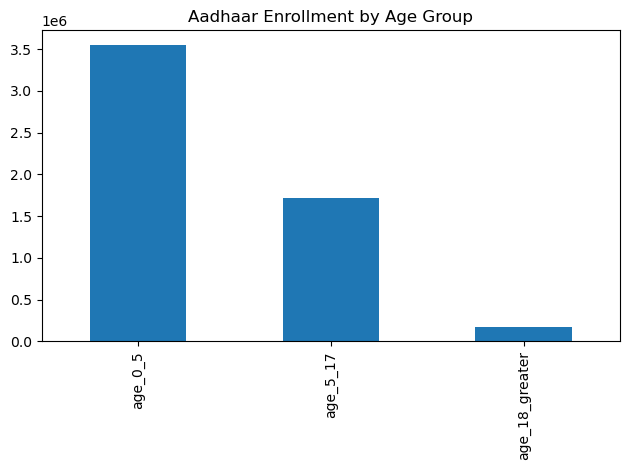

In [6]:
age_totals = df[['age_0_5', 'age_5_17', 'age_18_greater']].sum()

age_totals.plot(kind='bar', title="Aadhaar Enrollment by Age Group")
plt.tight_layout()
plt.show()

**Insight:**
Adult enrollment dominates Aadhaar registrations, indicating Aadhaar’s primary usage for identity verification and welfare delivery rather than early-age onboarding.

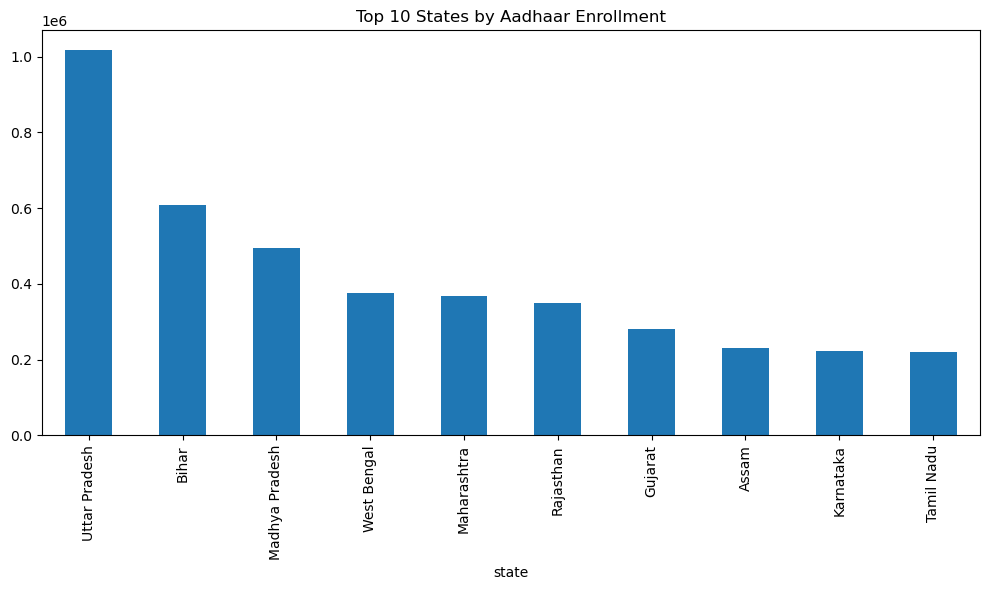

In [7]:
top_states = (
    df.groupby('state')['total_enrollment']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top_states.plot(
    kind='bar',
    figsize=(10,6),
    title="Top 10 States by Aadhaar Enrollment"
)

plt.tight_layout()
plt.show()

**Insight:**
A small number of states contribute a disproportionately large share of Aadhaar enrollments, highlighting regional imbalance in digital identity penetration.

## District-Level Enrollment Concentration

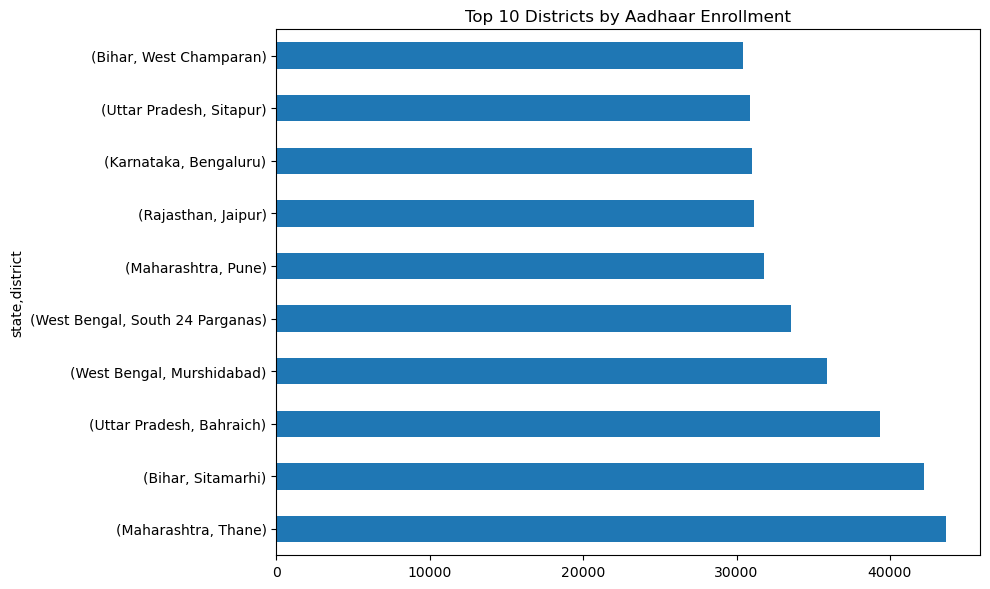

In [8]:
top_districts = (
    df.groupby(['state', 'district'])['total_enrollment']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top_districts.plot(
    kind='barh',
    figsize=(10,6),
    title="Top 10 Districts by Aadhaar Enrollment"
)
plt.tight_layout()
plt.show()

**Insight:**  
A small number of districts account for a disproportionately high share of Aadhaar enrollments, indicating uneven digital identity penetration even within high-performing states. This highlights the need for district-level targeting rather than state-level planning alone.


### District-Level Enrollment Inequality Across States


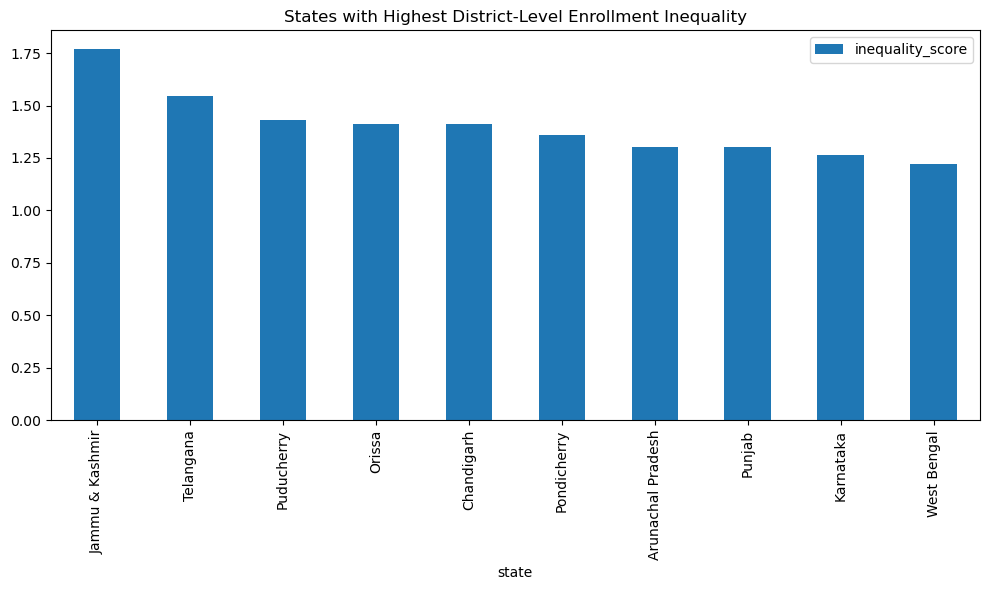

In [9]:
district_total = (
    df.groupby(['state', 'district'])['total_enrollment']
      .sum()
      .reset_index()
)

state_stats = (
    district_total.groupby('state')['total_enrollment']
    .agg(['mean', 'std'])
    .reset_index()
)

state_stats['inequality_score'] = state_stats['std'] / state_stats['mean']

top_inequality = state_stats.sort_values(
    'inequality_score', ascending=False
).head(10)

top_inequality.plot(
    x='state',
    y='inequality_score',
    kind='bar',
    figsize=(10,6),
    title="States with Highest District-Level Enrollment Inequality"
)

plt.tight_layout()
plt.show()

**Insight:**  
Some states show high district-level enrollment inequality, where a few districts dominate Aadhaar registrations. This indicates that state-level averages can mask local exclusion and reinforces the importance of district-level planning for equitable digital governance.


### District-Level Aadhaar Service Pressure


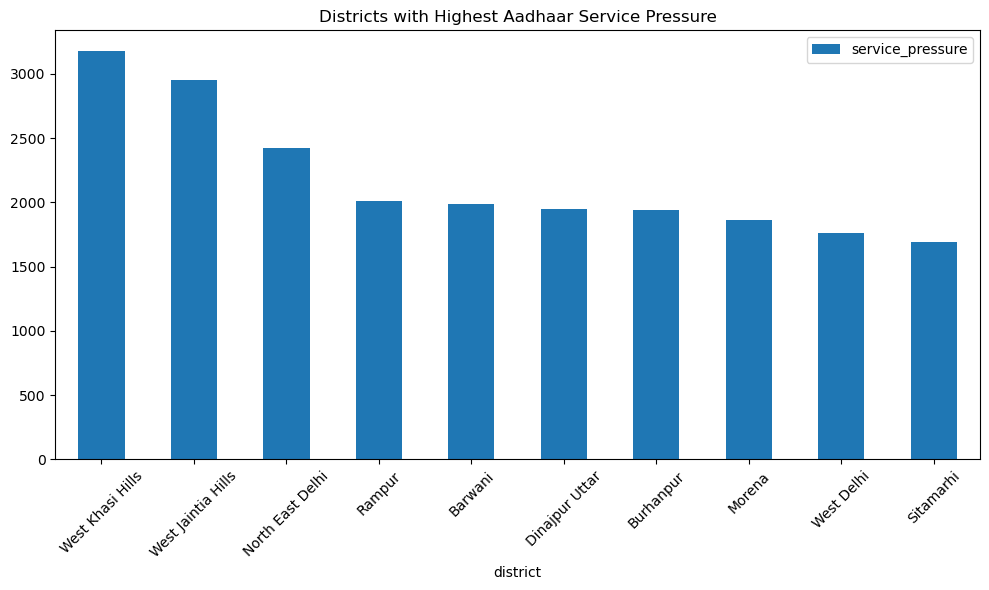

In [10]:
district_load = (
    df.groupby(['state', 'district'])
      .agg(
          total_enrollment=('total_enrollment', 'sum'),
          pincodes=('pincode', 'nunique')
      )
      .reset_index()
)

district_load['service_pressure'] = (
    district_load['total_enrollment'] / district_load['pincodes']
)

top_pressure = district_load.sort_values(
    'service_pressure', ascending=False
).head(10)

top_pressure.plot(
    x='district',
    y='service_pressure',
    kind='bar',
    figsize=(10,6),
    title="Districts with Highest Aadhaar Service Pressure"
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:**  
Districts with high Aadhaar service pressure may experience congestion, longer wait times, and operational strain. These districts are strong candidates for additional enrollment centers, mobile Aadhaar units, and capacity expansion.


### When State-Level Averages Become Misleading


In [11]:
# Choose a high-enrollment state
state_name = df.groupby('state')['total_enrollment'].sum().idxmax()

state_districts = (
    df[df['state'] == state_name]
    .groupby('district')['total_enrollment']
    .sum()
    .sort_values(ascending=False)
)

state_districts.head(10)


district
Bahraich        39338
Sitapur         30854
Agra            29910
Bareilly        27811
Aligarh         26192
Lucknow         25514
Hardoi          25193
Kanpur Nagar    24708
Kheri           24578
Shahjahanpur    24291
Name: total_enrollment, dtype: int64

**Insight:**  
Although the selected state appears to perform well at an aggregate level, enrollment is heavily concentrated in a small number of districts. This demonstrates how state-level averages can mask local disparities and why district-level analytics are critical for equitable digital governance.


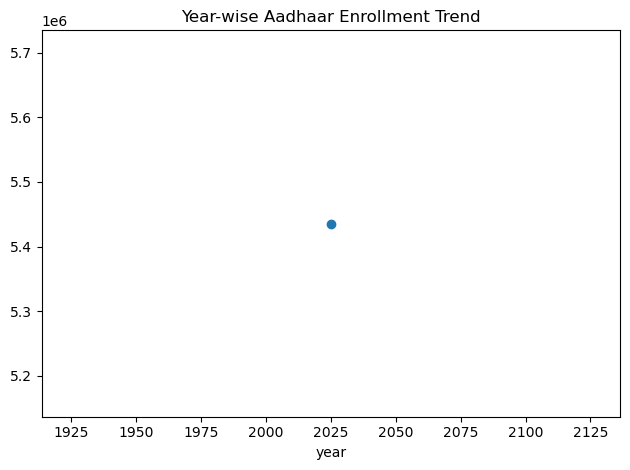

In [12]:
df['year'] = df['date'].dt.year

yearly_trend = df.groupby('year')['total_enrollment'].sum()

yearly_trend.plot(kind='line', marker='o', title="Year-wise Aadhaar Enrollment Trend")
plt.tight_layout()


**Insight:**

The available temporal data provides a snapshot of Aadhaar enrollment activity over time. While long-term trend interpretation is limited, the analysis highlights the potential of time-based enrollment monitoring for operational planning.

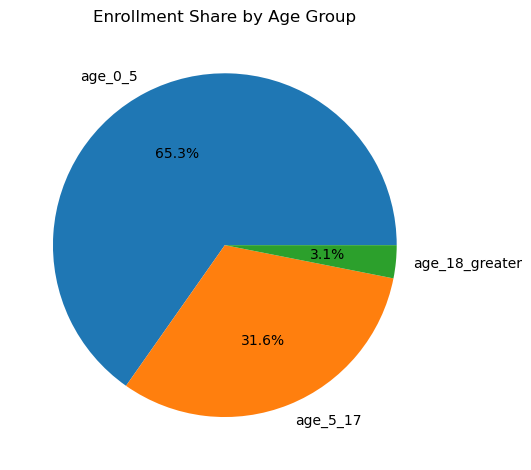

In [13]:
age_ratio = df[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
age_ratio.plot(kind='pie', autopct='%1.1f%%', title="Enrollment Share by Age Group")
plt.tight_layout()


**Insight:**

### Lower enrollment among children suggests scope for school-linked Aadhaar awareness programs.

## --------------------------------------------------------------------------------

## Governance Metrics Derived from the Analysis


Based on the exploratory analysis, the following governance-oriented metrics are derived:

- **District Enrollment Inequality Score** – Captures uneven distribution of Aadhaar enrollment within states  
- **Aadhaar Service Pressure Index** – Identifies districts facing high operational load and potential service bottlenecks  
- **Age-Group Enrollment Balance** – Highlights inclusion gaps across different age segments  

These metrics translate raw enrollment data into decision-support indicators that can assist UIDAI and policy-makers in targeted planning and efficient allocation of Aadhaar infrastructure.


## --------------------------------------------------------------------------------

## Why This Analysis Matters for UIDAI and Digital Governance


Aadhaar is a foundational pillar of India’s digital public infrastructure, enabling access to welfare schemes, financial services, and identity verification at scale. While enrollment numbers provide a surface-level view, understanding how enrollment is distributed across regions and districts is critical for inclusive governance.

This analysis goes beyond aggregate statistics to highlight district-level inequality, service pressure, and age-based inclusion gaps. By transforming public Aadhaar enrollment data into governance-oriented metrics, the study demonstrates how data-driven insights can support targeted interventions, optimize resource allocation, and strengthen the effectiveness of UIDAI’s service delivery ecosystem.


## --------------------------------------------------------------------------------

## * Limitations of the Analysis

- The dataset does not include population-normalized metrics, which may affect comparative interpretations.
- Demographic attributes such as gender and income are not available in the dataset.
- The analysis assumes consistent reporting standards across all regions and time periods.

Despite these limitations, the analysis provides meaningful directional insights for understanding Aadhaar enrollment patterns.


## --------------------------------------------------------------------------------

# Policy Recommendations

### 1.Deploy mobile Aadhaar enrollment units in low-performing districts
### 2.Integrate Aadhaar enrollment drives with school admissions
### 3.Focus awareness programs on rural and under-enrolled regions
### 4.Simplify enrollment for children and senior citizens
### 5.Use district-level analytics for targeted governance interventions

## --------------------------------------------------------------------------------

# CONCLUSION

### This project analyzed over one million Aadhaar enrollment records to understand enrollment patterns across age groups, regions, and time in India. Through exploratory data analysis, the study identified significant variations in Aadhaar adoption across states and age categories.

### The analysis revealed that adult enrollment (18+ years) forms the majority of Aadhaar registrations, highlighting Aadhaar’s critical role in identity verification, welfare distribution, and access to public services. In contrast, lower enrollment among children indicates opportunities for early-age inclusion through school-based enrollment initiatives. State-wise analysis further showed regional imbalances, suggesting the need for targeted digital inclusion strategies in underperforming areas.

### Overall, this project demonstrates how large-scale public datasets, when analyzed responsibly, can provide meaningful insights for policy-making and digital governance. Aadhaar enrollment analytics can serve as a powerful tool for identifying inclusion gaps and improving the effectiveness of government service delivery.